# Imports

In [256]:
#  Load the "autoreload" extension so that code can change
%load_ext autoreload
%reload_ext autoreload
from pathlib import Path

#  always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../')
from src.imports import *
from src.data.download_data import *
from src.data.fire_data import *
from src.data.read_data import *
from src.gen_functions import *
from src.features.build_features import *
import seaborn as sns
output_notebook()
# set font size 
plt.rcParams.update({'font.size': 16})

from datetime import timedelta
from scipy.stats import spearmanr
from matplotlib.ticker import MaxNLocator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

In [29]:
# transition from acceptable to unhealthy for sensitive group and to unhealthy. 
transition_dict = { 'PM2.5': [0, 35.5, 55.4, 1e3],
                  'PM10': [0, 155, 254, 1e3],
                  'O3':[0, 70 , 85, 1e3],
                  'SO2':[0, 75, 185, 1e3],
                  'NO2': [0, 100, 360, 1e3],
                  'CO': [0, 6.4, 12.5, 1e3]}

gas_list = ['PM2.5', 'PM10', 'O3', 'CO', 'NO2', 'SO2']

city_info = {'Country': 'Thailand',
 'City': 'Chiang Mai',
 'City (ASCII)': 'Chiang Mai',
 'Region': 'Chiang Mai',
 'Region (ASCII)': 'Chiang Mai',
 'Population': '200952',
 'Latitude': '18.7904',
 'Longitude': '98.9847',
 'Time Zone': 'Asia/Bangkok'}

x = merc_x(city_info['Longitude'])
y = merc_y(city_info['Latitude'])

In [7]:
b_folder='../data/pm25/'
a4th_folder ='../data/air4thai_hourly/'
cm_folder ='../data/cm_proc/'
cdc_folder = '../data/cdc_data/'
aqm_folder = '../data/aqm_hourly2/'

In [105]:
aqm1 = pd.read_csv(cm_folder + '35t.csv').set_index('datetime').dropna(how='all')
aqm1.index = pd.to_datetime(aqm1.index)
aqm2 = pd.read_csv(cm_folder + '36t.csv').set_index('datetime').dropna(how='all')
aqm2.index = pd.to_datetime(aqm2.index)
print(aqm2.columns)
# keep only the data after the satallite data which is 200-11-11 13 am
aqm2_01 = aqm2[aqm2.index>='2000-11-01 00:00:00'].copy()
aqm2_01 = add_season(aqm2_01)
print(aqm2_01.shape)

# weather data 
filename = 'C:/Users/Benny/Documents/Fern/aqi_thailand2/data/weather_cities/Mueang_Chiang_Mai.csv'
wea = pd.read_csv(filename)
wea.drop(['Time','Dew Point(C)','Wind Gust(kmph)','Pressure(in)','Precip.(in)'], axis=1, inplace=True)
wea['datetime'] = pd.to_datetime(wea['datetime'])
# merge with weather 

aqm2_01 = aqm2_01.merge(wea, left_index=True, right_on ='datetime',how='inner').set_index('datetime')
print(aqm2_01.shape)

Index(['CO', 'O3', 'NO2', 'SO2', 'PM10', 'PM2.5'], dtype='object')
(168169, 8)
(165291, 13)


In [215]:
fire = pd.read_csv('C:/Users/Benny/Documents/Fern/aqi_thailand2/data/cm_proc/file_m_proc.csv')
fire['datetime'] = pd.to_datetime(fire['datetime'])
fire = fire.set_index('datetime')
fire.head()

,confidence,lat_km,long_km,distance,power,count
datetime,,,,,,
2002-07-04 13:03:00,67,1612.0,11453.0,665.551109,120.96,1
2002-07-04 13:04:00,52,2246.0,11701.0,694.254989,20.52,1
2002-07-04 13:04:00,48,2304.0,11682.0,689.069015,13.50,1
2002-07-04 13:04:00,91,2305.0,11682.0,689.341767,132.30,1
2002-07-04 13:05:00,62,2428.0,11936.0,968.527252,10.45,1


# Feature Engineering Functions

In [118]:
def wind_to_dummies(series):
    """One hot encode wind direction columns and group major wind direction
    
    """
    series = series.astype('category')
    dummies = pd.get_dummies(series)

    # group the wind direction into major wind direction 
    direction_to_collpse = ['ENE', 'ESE', 'NE', 'NNE', 'NNW', 'NW', 'SE', 'SSE', 'SSW', 'SW',  'WNW', 'WSW']

    for direction in direction_to_collpse:
        if len(direction)>1:
            for char in set(direction):
                dummies[char] = dummies[char] + dummies[direction]
            dummies.drop(direction, axis=1,inplace=True)

    # group the 'var' direction
    major_direction = ['E','N','S','W']
    for direction in major_direction:
        dummies[direction] = dummies[direction] + dummies['VAR']
    dummies.drop('VAR',axis=1,inplace=True)
    dummies.columns = ['wind_' + s for s in dummies.columns ]
    return dummies

def add_is_rain(df,rain_list=['Rain','Shower','Thunder','Strom','Drizzle']):
    df['is_rain'] = df['Condition'].str.contains('|'.join(rain_list))*1
    df = df.drop('Condition', axis=1)
    return df


In [249]:
# function for feature eng fire
def cal_power_damp(series: pd.core.series.Series, distance: pd.core.series.Series, surface='sphere'):
    """ Calculate the damped power based on the distance series. 

    The damping factor maybe 1/distance or 1/distance**2.
    Args: 
        series: series to recalculate
        distance: distance array. Must have the same lenght as the series
        surface(optional): either 'circle' or 'sphere'

    Returns:
        new_series

    Examples:
        cal_power_damp(fire['power'], fire['distance'],surface='sphere')

    """
    if surface == 'sphere':
        new_series = series/distance**2

    elif surface == 'circle':
        new_series = series/distance

    return new_series


def cal_arrival_time(detection_time: pd.core.series.Series, distance: pd.core.series.Series, wind_speed: (float, np.array) = 2):
    """ Calculate the approximate time that the pollution arrived at the city using the wind speed and distance from the hotspot.

    Round arrival time to hour 

    Args:
        detection_time: datetime series
        distance: distance series in km
        wind_speed(optional): approximate wind speed, can be floar or array in km/hour

    Returns: 
        arrival_time: datetime series of arrival time

    """
    arrival_time = detection_time + pd.to_timedelta(distance/wind_speed, 'h')
    return arrival_time.dt.round('H')


def shift_fire(fire_df: pd.core.frame.DataFrame, fire_col: str = 'power', damp_surface: str = 'sphere', shift: int = 0, roll: int = 48, w_speed: (float, int) = 8):
    """ Feature engineer fire data. Account of the distance from the source and time lag using wind speed.

    Args:
        fire_df:
        fire_col
        damp_surface
        shift
        roll

    """
    require_cols = ['distance', fire_col]
    if fire_df.columns.isin(require_cols).sum() > len(require_cols):
        raise AssertionError(
            'missing required columns for feature engineering fire data')

    # calculate the damping factors
    fire_df['damp_'+fire_col] = cal_power_damp(
        fire_df[fire_col], fire_df['distance'], surface=damp_surface)
    # calculate particle arrival time
    fire_df['arrival_time'] = cal_arrival_time(
        detection_time=fire_df.index, distance=fire_df['distance'], wind_speed=w_speed)
    fire_df = fire_df.set_index('arrival_time')
    fire_df = fire_df.resample('h').sum()['damp_'+fire_col]
    fire_df = fire_df.rolling(roll).sum()
    fire_df = fire_df.shift(shift)
    fire_df.index.name = 'datetime'
    return fire_df


def get_fire_feature(fire, zone_list=[0, 100, 200, 400, 800, 1000], fire_col: str = 'power', damp_surface: str = 'sphere', shift: int = 0, roll: int = 48, w_speed: (float, int) = 8):
    """ Separate fire from different distance

    """
    fire_col_list = []
    new_fire = pd.DataFrame()
    for start, stop in zip(zone_list, zone_list[1:]):
        col_name = f'fire_{start}_{stop}'

        fire_col_list.append(col_name)
        # select sub-data baseline the distance
        fire_s = fire[(fire['distance'] < stop) & (fire['distance'] >= start)][[fire_col, 'distance']].copy()
        fire_s = shift_fire(fire_s, fire_col=fire_col, damp_surface=damp_surface,
                            shift=shift, roll=roll, w_speed=w_speed)
        fire_s.name = col_name
        new_fire = pd.concat([new_fire, fire_s], axis=1, ignore_index=False)

    new_fire = new_fire.fillna(0)
    return new_fire, fire_col_list

def sep_fire_zone(fire, fire_col, zone_list=[0, 100, 200, 400, 800, 1000]):
    """ Separate fire data into zone mark by a distance in the zone_list without perform feature enginering.
    Use for data visualization
    
    Args: 
        fire: fire dataframe
        fire_col: 'power' or 'count'
        zone_list:
        
    Return: 
        new_fire: a dataframe with each column, a fire data in that zone
        fire_col_list: a list of column name
    
    """
    fire_col_list = []
    new_fire = pd.DataFrame()
    for start, stop in zip(zone_list, zone_list[1:]):
        col_name = f'fire_{start}_{stop}'
        fire_col_list.append(col_name)
        # select sub-data baseline the distance
        fire_s = fire[(fire['distance'] < stop) & (fire['distance'] >= start)][[fire_col]].copy()
        fire_s.columns = [col_name]
        fire_s = fire_s.resample('h').sum()
        new_fire = pd.concat([new_fire, fire_s], axis=1, ignore_index=False)

    return new_fire, fire_col_list

In [85]:
def add_calendar_info(df, holiday_file='C:/Users/Benny/Documents/Fern/aqi_thailand2/data/th_holiday.csv'):
    """ Add information related to calendar such as holiday, is_weekend, day of week and time of day. 
    
    Args:
        df: data frame with datetime index, 
    """
    # add datetime information 
    df = add_is_holiday(df, holiday_file)
    # add weekend information 
    df['is_weekend'] = df.index.dayofweek.isin([5,6])*1
    # add day of week
    df['day_of_week'] = df.index.dayofweek
    df['time_of_day'] = df.index.time
    
    return df

In [254]:
def plot_dendogram(data,cols=None,front_size=16):
    if cols==None:
        cols = data.columns
    # Redundant Features
    corr = np.nan_to_num(np.round(spearmanr(data[cols]).correlation, 4))
    
    for i in range(corr.shape[0]):
        corr[i,i] = 1
    
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr, method='average')
    _, ax = plt.subplots(figsize=(16,10))
    dendrogram = hc.dendrogram(z, labels=cols, orientation='left', leaf_font_size=front_size)
    return ax

In [325]:
def split_data(data, shuffle=False,val_size=0.3, test_size=0.25):
    trn, test = train_test_split(data, test_size=test_size, shuffle=False)
    trn, val  = train_test_split(trn, test_size=val_size, shuffle=False)
    print('train size', len(trn))
    print('validation size',len(val))
    print('test size',len(test))
    return trn,  val, test

# get data 
def get_data(data, pollutant:str, shuffle=False, val_size=0.3, test_size=0.25):
    """Obtain xtrn, ytrn, xval, yval, xtest, ytest
    
    """
    y = data[pollutant]
    x = data.drop(pollutant,axis=1)
    data_index = data.index

    trn_idx, val_idx, test_idx = split_data(data_index,shuffle=shuffle, val_size=val_size, test_size=test_size)
    ytrn = y.loc[trn_idx].values
    xtrn = x.loc[trn_idx].values

    yval = y.loc[val_idx].values
    xval = x.loc[val_idx].values

    ytest = y.loc[test_idx].values
    xtest = x.loc[test_idx].values
    
    return xtrn, ytrn, xval, yval, xtest, ytest

In [295]:
def display_time_split(trn_idx, val_idx, test_idx):
    """ Display how the time series data is split
    
    """
    
    fig, ax = plt.subplots(figsize=(9, 2.5))
    # Plot training and test indices
    l1 = ax.scatter(trn_idx, [1] * len(trn_idx), c='royalblue', marker='_', lw=6)
    l2 = ax.scatter(val_idx, [1] * len(val_idx), c='orange', marker='_', lw=6)
    l3 = ax.scatter(test_idx, [1] * len(test_idx), c='red', marker='_', lw=6)
    ax.legend([l1, l2, l3], ['Training', 'Validation','Test'])
    ax.set(ylim=[0.8, 1.5], title='Split behavior', xlabel='date')
    plt.xticks(rotation=90)

# Model PM2.5

In [289]:
# load the data and keep only relavant data 
pollutant = 'PM2.5'
cols = [pollutant, 'Temperature(C)', 'Humidity(%)', 'Wind', 'Wind Speed(kmph)', 'Condition']
data = aqm2_01[cols].dropna()

if pollutant == 'PM2.5':
    data = data.loc['2010':]
data.head(1)

,PM2.5,Temperature(C),Humidity(%),Wind,Wind Speed(kmph),Condition
datetime,,,,,,
2011-05-17 16:00:00,1.0,27.22,74.0,NE,10.0,Mostly Cloudy


In [290]:
## Featuare Eng Fires

# fire feature engineering parameters 
# fire column either 'power' or 'count'
fire_col = 'power'
# surface damping factor
damp_surface = 'sphere'
# shifting of the data
shift = 0
# rolling average parameter (in hour)
roll = 48
# effective wind speed (km/h)
w_speed = 8

fire_proc, fire_col_list = get_fire_feature(fire, zone_list=[0, 100, 200, 400, 800, 1000], 
                        fire_col=fire_col,damp_surface=damp_surface, 
                        shift=shift, roll=roll, w_speed=w_speed)
print(fire_col_list)

['fire_0_100', 'fire_100_200', 'fire_200_400', 'fire_400_800', 'fire_800_1000']


(0, 12)

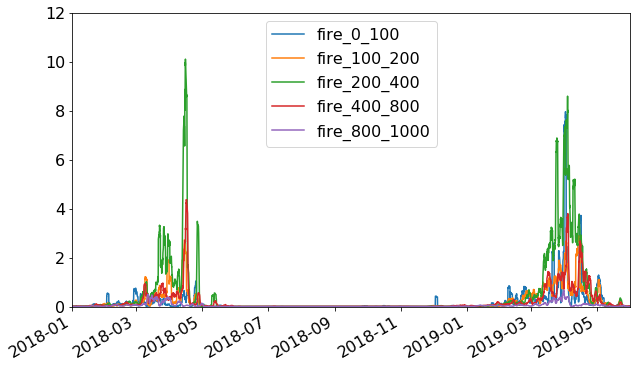

In [252]:
fire_proc[fire_col_list].plot(figsize=(10,6))
plt.xlim(['2018', '2019-06'])
plt.ylim([0,12])

In [291]:
# inner joint fire with pm data
print('data before merge has shape', data.shape)
data = data.merge(fire_proc, left_index=True, right_index=True, how='inner')
print('data after merge has shape', data.shape)

# add weather 
dummies = wind_to_dummies(data['Wind'])
data.drop('Wind',axis=1, inplace=True)
data = pd.concat([data, dummies], axis=1)
data = add_is_rain(data)
data.head()

data before merge has shape (74412, 6)
data after merge has shape (73753, 11)


,PM2.5,Temperature(C),Humidity(%),Wind Speed(kmph),fire_0_100,fire_100_200,fire_200_400,fire_400_800,fire_800_1000,wind_CALM,wind_E,wind_N,wind_S,wind_W,is_rain
2011-05-17 16:00:00,1.0,27.22,74.0,10.0,4.662937e-15,1.133425e-15,0.461022,0.089941,0.019173,0,1,1,0,0,0
2011-05-17 17:00:00,1.0,25.00,83.0,10.0,4.662937e-15,1.133425e-15,0.461022,0.079056,0.020172,0,1,0,0,0,0
2011-05-17 18:00:00,1.0,25.00,78.0,5.0,4.662937e-15,1.133425e-15,0.461022,0.068221,0.018986,0,0,0,1,1,0
2011-05-17 19:00:00,1.0,25.00,83.0,3.0,4.662937e-15,1.133425e-15,0.461022,0.067909,0.017363,0,0,0,1,1,0
2011-05-17 20:00:00,11.0,25.00,83.0,10.0,4.662937e-15,1.133425e-15,0.461022,0.067391,0.016916,0,0,0,1,1,0


# Hierarcal relationship among features

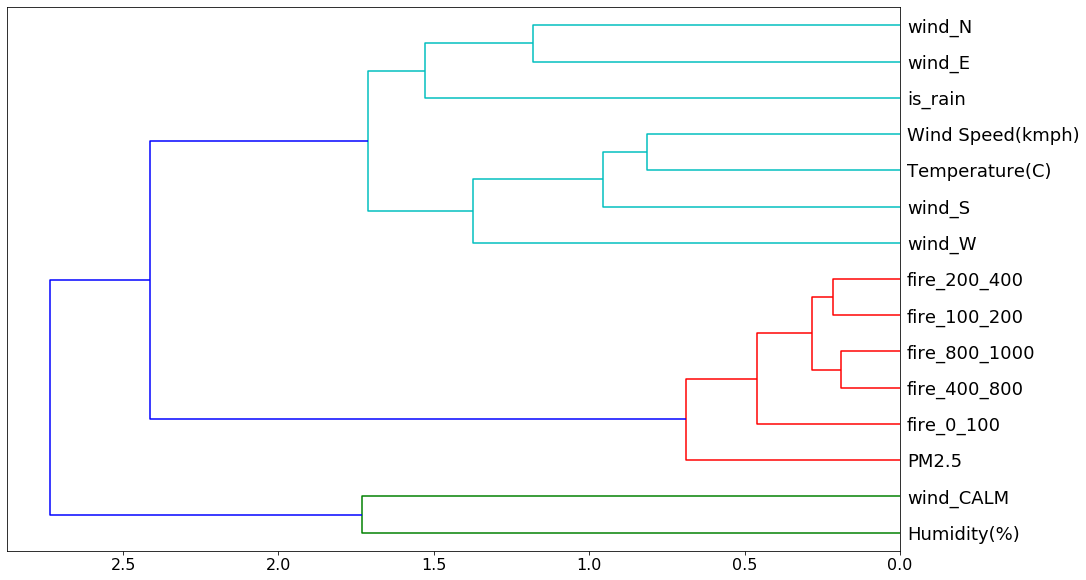

In [293]:
ax = plot_dendogram(data,front_size=18)

# Train and Test Split

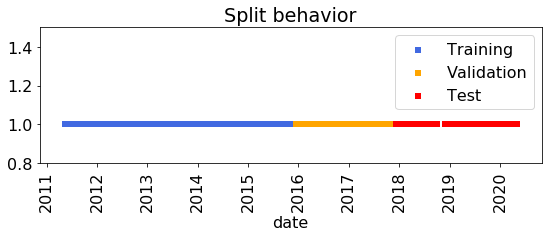

In [296]:
display_time_split(trn_idx, val_idx, test_idx)

In [326]:
xtrn, ytrn, xval, yval, xtest, ytest = get_data(data, pollutant=pollutant, shuffle=False, val_size=0.3, test_size=0.25)
xtrn.shape

train size 38719
validation size 16595
test size 18439


(38719, 14)

# RF Feature of Important Search

In [328]:
def do_rf_search(x_trn,y_trn,cv_split='time', n_splits=5):
    ''' Randomize search for randomforest regressor
    return the best estimator 
    
    '''
    # rf 
    m = RandomForestRegressor(n_jobs=-1, random_state=42)
    
    param_dist = {'n_estimators':range(20,200,20),
              'max_depth': [3, None],
              'min_samples_split' : [2, 5, 10], 
              'max_features' : range(2,x_trn.shape[1]),
               'bootstrap' : [True, False],
              'min_samples_leaf': range(1, 8)}
    
    if cv_split =='time':
        cv = TimeSeriesSplit(n_splits=n_splits)
        
    else:
        cv = n_splits
    #hyper parameter tuning
    search = RandomizedSearchCV(m, param_distributions=param_dist,
                            n_iter=100,n_jobs=-1, cv=cv, random_state=40)
    
    search.fit(x_trn,y_trn)
    print(search.best_params_, search.best_score_)
    
    return search.best_estimator_

In [ ]:
%%time
best_rf = do_rf_search(xtrn, ytrn,cv_split='time', n_splits=5)